# Basic tutorial of the lgpr package
Here we generate an artificial longitudinal data set and analyse it.

In [1]:
require(lgpr)
require(repr)
require(ggplot2)

Loading required package: lgpr
Hello, this is lgpr (version 0.27.7).
Loading required package: repr
Loading required package: ggplot2


## 1. Simulating data
In this example we generate a data set with 16 individuals and 6 measurement time points for each. 

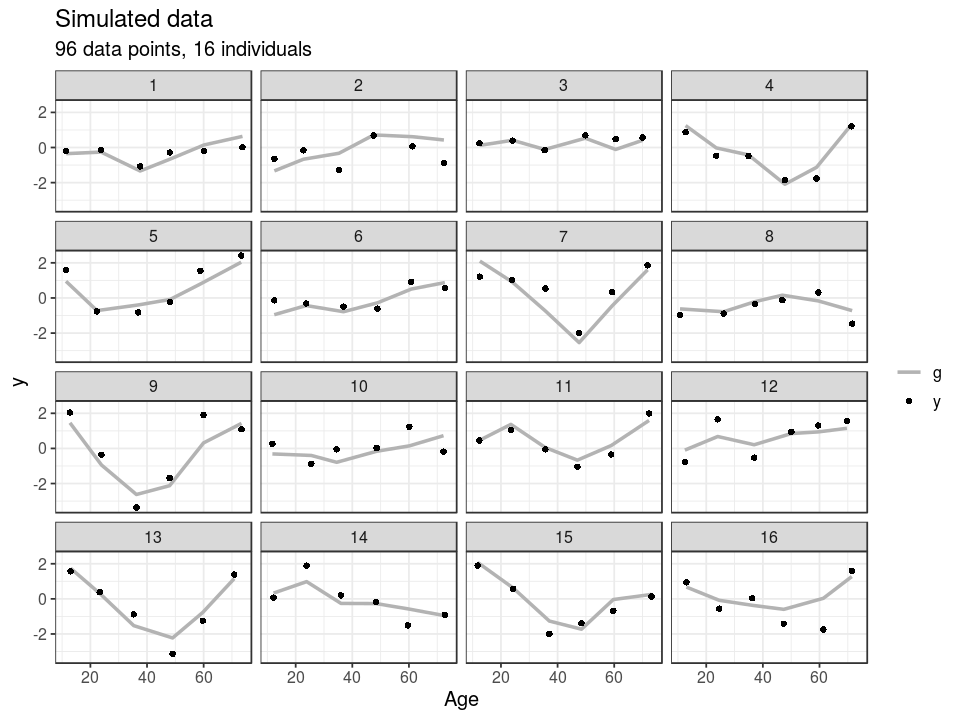

In [2]:
set.seed(123)
simData <- simulate_data(N           = 16,
                        t_data       = seq(12, 72, by = 12),
                        covariates   = c(    2,2),
                        lengthscales = c(12,24,12,12),
                        relevances   = c(1,1,1,0),
                        names        = c("sex", "location"),
                        t_jitter     = 1.0)

FONT_SIZE <- 12
options(repr.plot.width=8, repr.plot.height=6)

# plot data for each individual separately
plot_simdata(simData) + theme(text=element_text(size=FONT_SIZE)) 

As can be seen from the following plot, the data was generated so that covariates age, id, and sex are relevant, whereas location is not.

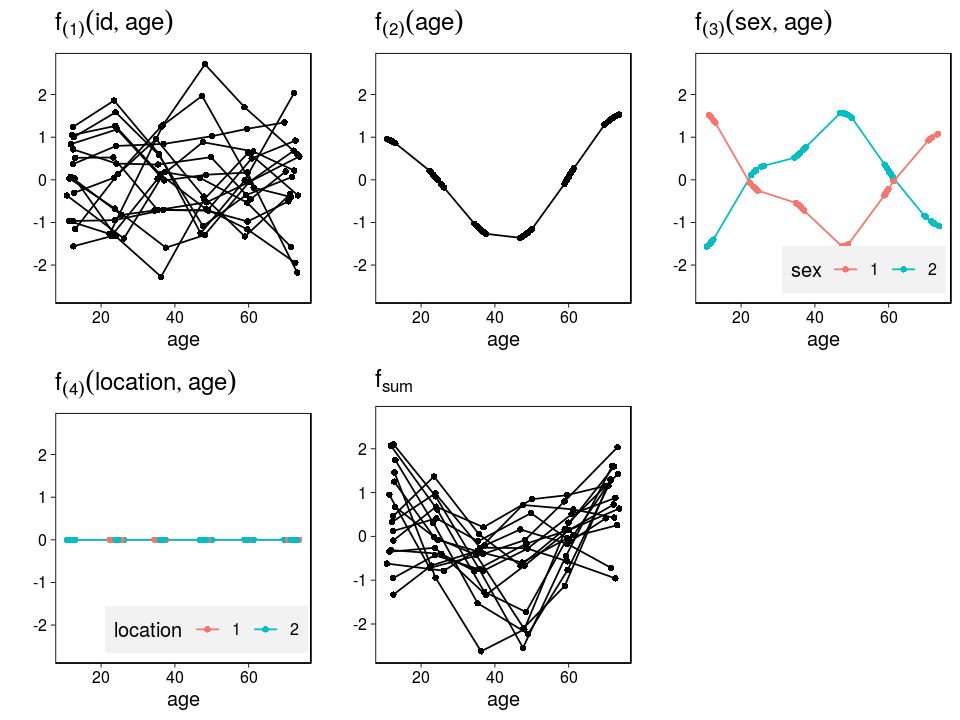

In [3]:
# plot each generated component separately
plot_components_simdata(simData, font_size = FONT_SIZE) 

## 2. Fitting a model
We fit a model with all covariates included. In general, it would be a good idea to use multiple, longer chains (arguments `iter` and `chains`).

In [4]:
fit <- lgp(formula  = y ~ id + age + sex + location,
           data     = simData$data,
           iter     = 2000, 
           chains   = 2,
           refresh  = 0,
           verbose  = TRUE)

* Covariate 'sex' resolved to type 'categorical'.
* Covariate 'location' resolved to type 'categorical'.

 ---------- LGPMODEL SUMMARY ----------

  Model:
    f = f[(1)](id, age) + f[(2)](age) + f[(3)](sex, age) + f[(4)](location, age)
    Response variable: y
    Observation model: Gaussian 
  Variable types:
    - Identifier variable: id
    - Time variable: age
    - Other categorical variables: sex, location
  Observation model: Gaussian

 ---------- PRIOR SPECIFICATIONS ----------

  alpha_id ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_age ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[1] ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[2] ~ Student-t(nu=20,mu=0,sigma=1)

  ell_id ~ Log-Normal(0,1)
  ell_age ~ Log-Normal(0,1)
  ell_categAge[1] ~ Log-Normal(0,1)
  ell_categAge[2] ~ Log-Normal(0,1)

  (sigma_n)^2 ~ Inverse-Gamma(2,1)

 
* Observation model = 1
* Number of data points = 96
* Number of model components = 4
* Number of individuals = 16
* Additional model info:
  - D = [

The covariate relevances are reported above. As is seen, the location covariate is not selected and therefore correctly classified as irrelevant.

## 3. Interpreting the results
We can visualize the inferred covariate effects and confirm that the effect of location is very small compared to that of other covariates. 

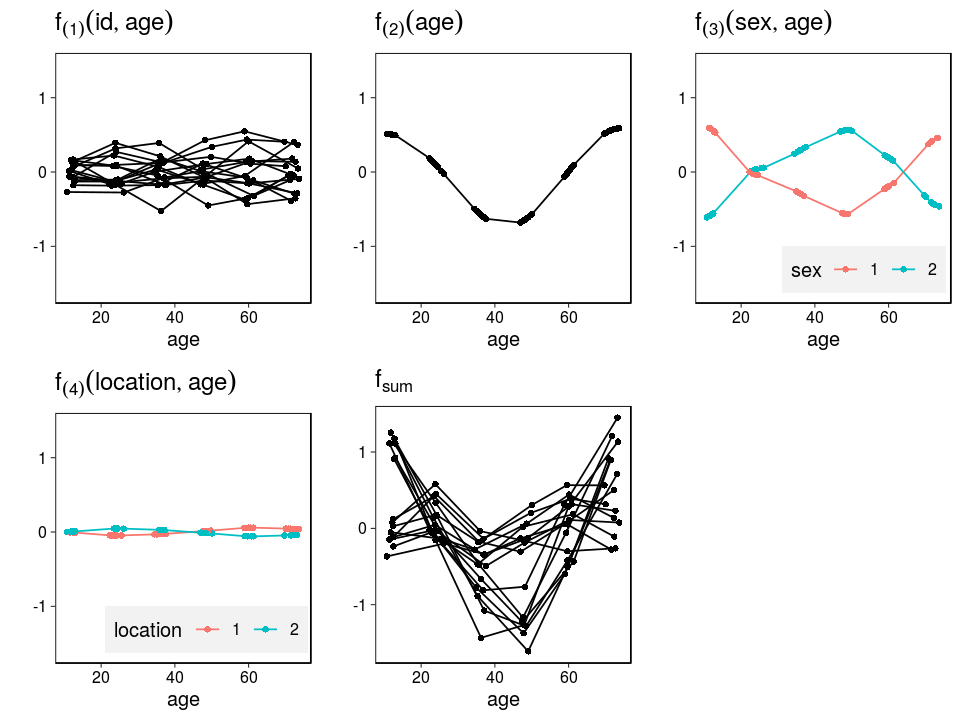

In [5]:
plot_components_posterior(fit, font_size = FONT_SIZE)

In [29]:
require(rstan)
SMP <- rstan::extract(fit@stan_fit, pars = c("F_mean_cmp"))$F_mean_cmp
SMP <- SMP[1,,,]
#print(SMP)
#print(simData$data)

Here we compute the posterior distributions of each component ($f_{(j)}$), and the sum of all components ($f_{sum}$) at a dense time grid of 100 points, using MAP hyperparameter estimates. For each component, the shaded ribbons indicate the $95\%$ posterior interval, and the solid lines are the posterior mean.

   id      age sex location
1   1 11.43952   2        1
2   1 23.76982   2        1
3   1 37.55871   2        1
4   1 48.07051   2        1
5   1 60.12929   2        1
6   1 73.71506   2        1
7   2 12.46092   2        1
8   2 22.73494   2        1
9   2 35.31315   2        1
10  2 47.55434   2        1
11  2 61.22408   2        1
12  2 72.35981   2        1
13  3 12.40077   2        1
14  3 24.11068   2        1
15  3 35.44416   2        1
16  3 49.78691   2        1
17  3 60.49785   2        1
18  3 70.03338   2        1
19  4 12.70136   1        1
20  4 23.52721   1        1
21  4 34.93218   1        1
22  4 47.78203   1        1
23  4 58.97400   1        1
24  4 71.27111   1        1
25  5 11.37496   1        1
26  5 22.31331   1        1
27  5 36.83779   1        1
28  5 48.15337   1        1
29  5 58.86186   1        1
30  5 73.25381   1        1
31  6 12.42646   2        2
32  6 23.70493   2        2
33  6 36.89513   2        2
34  6 48.87813   2        2
35  6 60.82158   2  

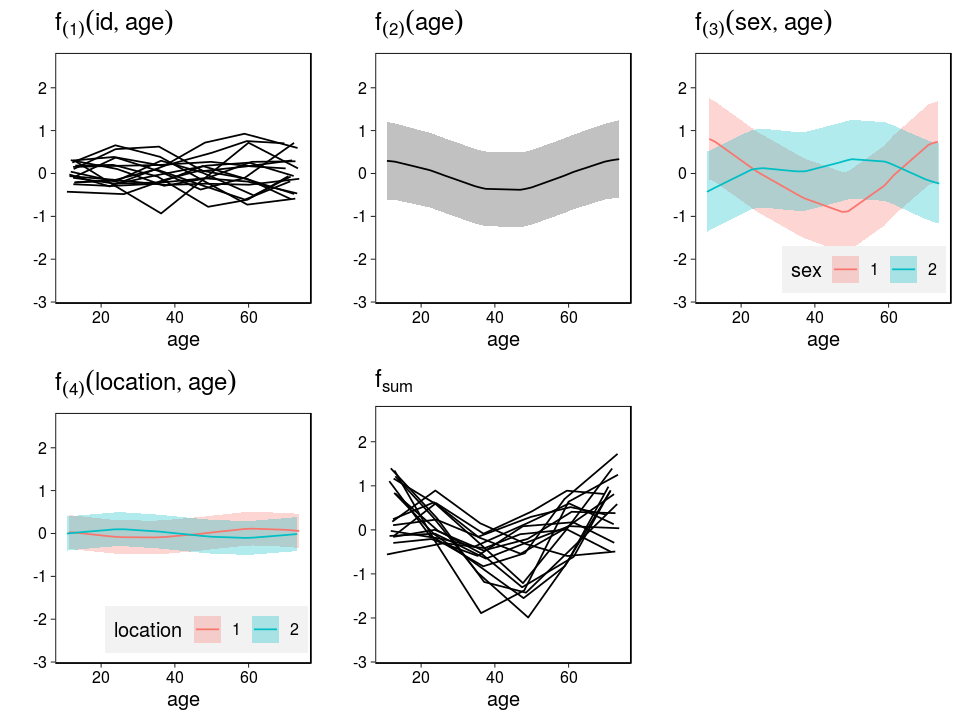

In [32]:
ttt    <- seq(0, 100, length.out = 20)
X_pred <- create_test_points(fit, ttt)
X_pred <- simData$data[,1:4]
print(X_pred)
PRED   <- lgp_predict(fit, X_pred, samples = 'map')
p      <- plot_components_posterior(fit, PRED=PRED, font_size = FONT_SIZE)
p

To confirm that the fitted model makes sense, we can plot the posterior predictive distribution of the model, for each individual, along with the data points.

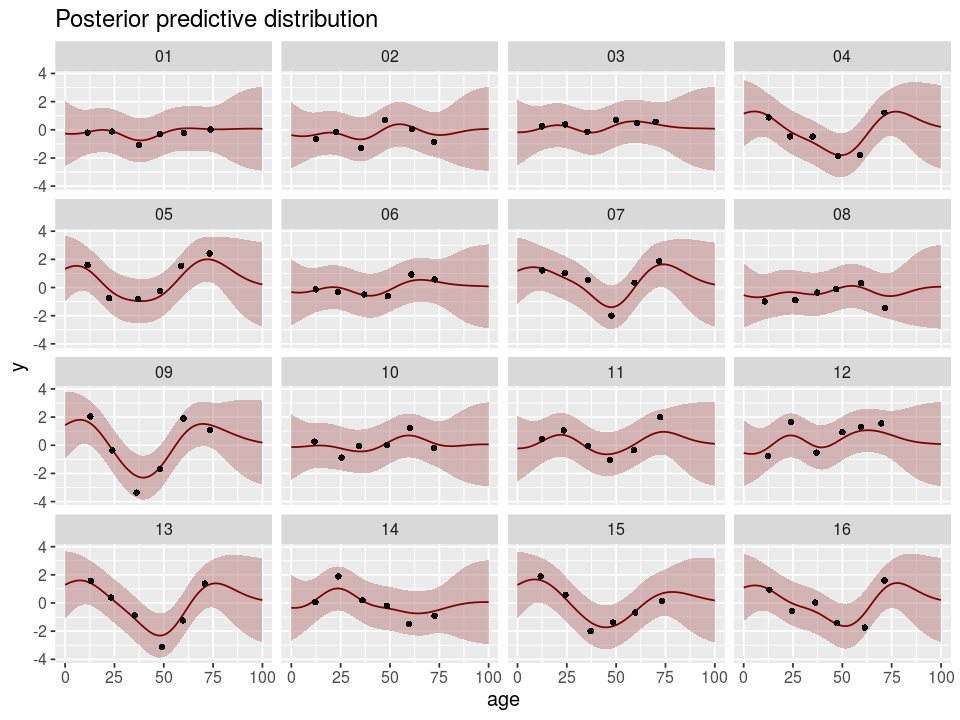

In [15]:
plot_posterior_y(fit, PRED) + theme(text=element_text(size=FONT_SIZE))

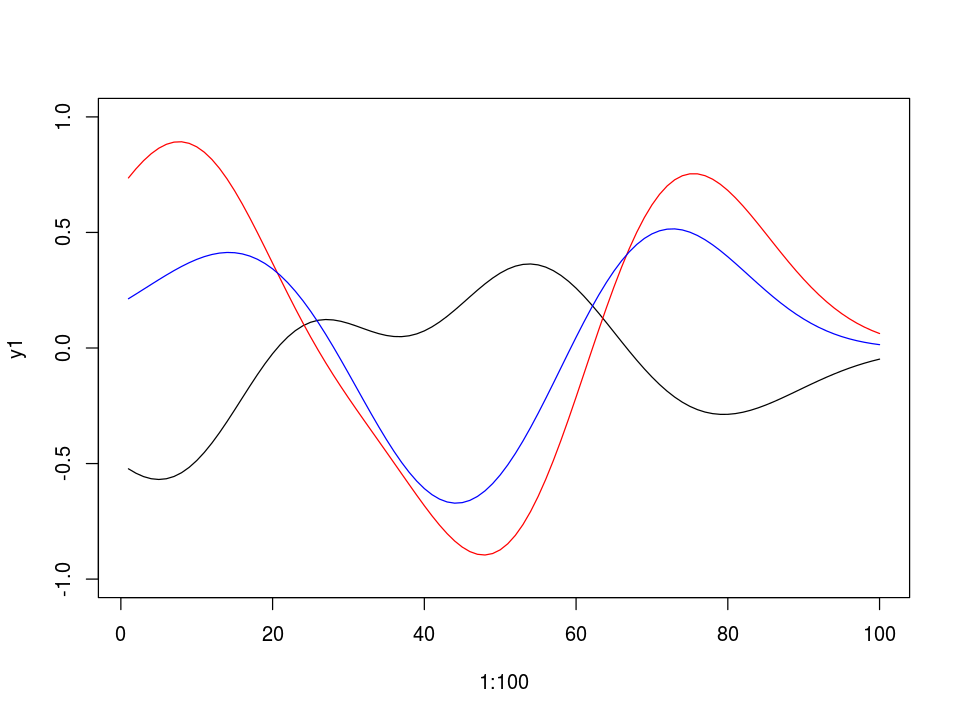

In [26]:
pl <- PRED$LIST[[1]]$mu_cmp[,3]
y1 <- pl[1:100]
y2 <- pl[401:500]
plot(1:100, y1, 'l', ylim = c(-1,1))
lines(1:100, y2, col = 'red')
lines(1:100, y1 + y2, col = 'blue')

In [33]:
print(fit@model@stan_dat$N_cat)

[1] 16  2  2
